# Basic Neural Networks 

(to compare pre-transfer learning)

In [2]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

In [14]:
recon_model_path = '/home/julias/MLEE-final-project/models/saved_models/recon_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [3]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

In [4]:
X_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_unseen.nc').to_dataframe().dropna() 
y_unseen_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_unseen.nc').to_dataframe().dropna() 

### Create Numpy Arrays for Original Data

In [15]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

In [16]:
X_df_norm = (X_df - X_df.mean())/X_df.std() 
y_df_norm = (y_df - y_df.mean())/y_df.std()
X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

### Create Numpy Arrays for Normalized Data

In [17]:
X = X_df_norm.to_numpy()         
y = y_df_norm.to_numpy().ravel() 
X_train = X_train_df_norm.to_numpy()
y_train = y_train_df_norm.to_numpy().ravel()
X_test = X_test_df_norm.to_numpy() 
y_test = y_test_df_norm.to_numpy().ravel()

# Preliminary NN Model using Original (Not Normalized) Input

## Build NN Model

In [36]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [37]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [39]:
y_train_df.shape[1]

1

In [40]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_original.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(1,  activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [41]:
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                704       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [43]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_original, y_train_original, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 407.2504 - val_loss: 592.4200
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 385.2867 - val_loss: 521.6102
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 364.4340 - val_loss: 447.0561
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 346.6915 - val_loss: 391.2883
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 332.6898 - val_loss: 507.0449
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 314.4771 - val_loss: 397.6451
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 298.3470 - val_loss: 374.3138
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 284.3664 - val_loss: 367.9523
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 270.0281 - val_loss: 401.4002
Epoch 10/50
2483/2483 [=======================

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

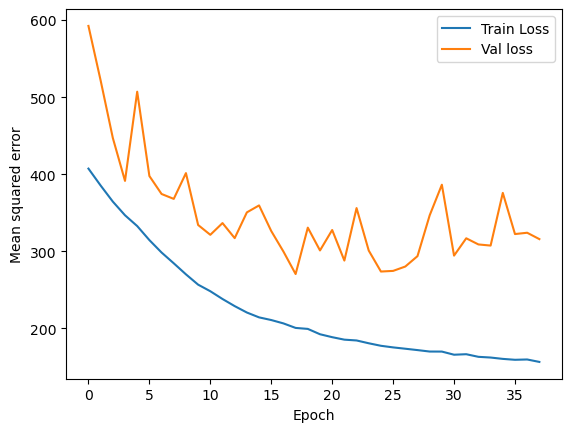

In [44]:
model_utils.plot_history(history)

Validation loss does jump around and is generally higher than the training loss, indicating that the model isn't generalizing well

### Normalize so more comparable to other plot

In [68]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [76]:
norm_loss = (history.history['loss'] - np.mean(history.history['loss'])) / np.std(history.history['loss'])

In [77]:
norm_val_loss = (history.history['val_loss'] - np.mean(history.history['val_loss'])) / np.std(history.history['val_loss'])

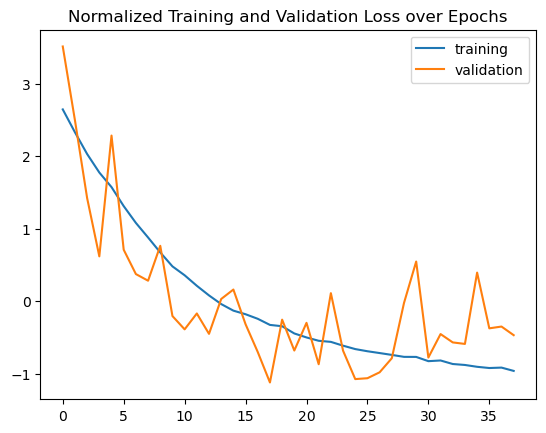

In [79]:
x_ax = history.epoch
plt.plot(x_ax, norm_loss, label="training")
plt.plot(x_ax, norm_val_loss, label="validation")
plt.title("Normalized Training and Validation Loss over Epochs")
plt.legend()
plt.show()

## Save NN Model

In [46]:
# after training, save:
NN_model.save(os.path.join(recon_model_path,'NN_model_oprelim_1.h5'))

## Test NN Model

In [47]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(recon_model_path,'NN_model_oprelim_1.h5'))

In [48]:
y_pred = NN_prelim_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 698us/step
MSE: 199.98


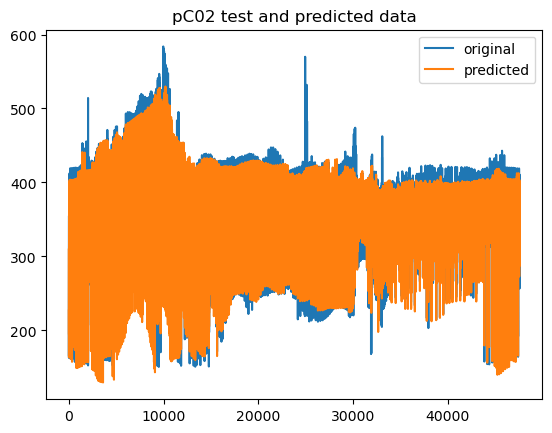

In [49]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Preliminary NN Model using Normalized Input

## Build NN Model

In [23]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [25]:
NN_model_nprelim = Sequential()

NN_model_nprelim.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nprelim.add(Dense(1,  activation='linear')) # the output layer


NN_model_nprelim.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [26]:
NN_model_nprelim.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                704       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nprelim = NN_model_nprelim.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 0.1927 - val_loss: 0.2070
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1188 - val_loss: 0.2189
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1014 - val_loss: 0.1905
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0932 - val_loss: 0.1839
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0874 - val_loss: 0.1771
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0827 - val_loss: 0.2050
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0804 - val_loss: 0.1663
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0773 - val_loss: 0.1946
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0746 - val_loss: 0.1709
Epoch 10/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.073

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

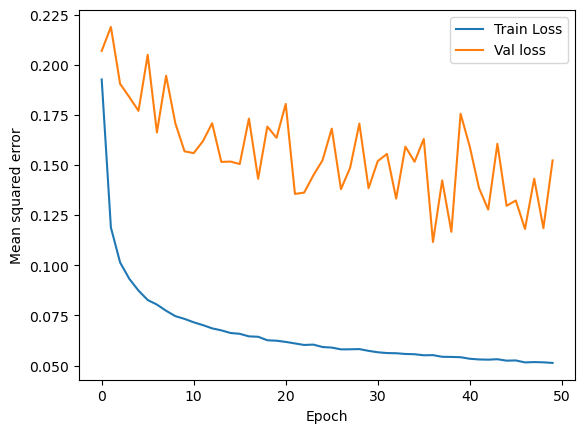

In [50]:
model_utils.plot_history(history_nprelim)

While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
- Completely fine, just signals that hyperparameter tuning will be needed (as expected)

### Normalize so more comparable to other plot

In [83]:
norm_nloss = (history_nprelim.history['loss'] - np.mean(history_nprelim.history['loss'])) / np.std(history_nprelim.history['loss'])

In [84]:
norm_val_nloss = (history_nprelim.history['val_loss'] - np.mean(history_nprelim.history['val_loss'])) / np.std(history_nprelim.history['val_loss'])

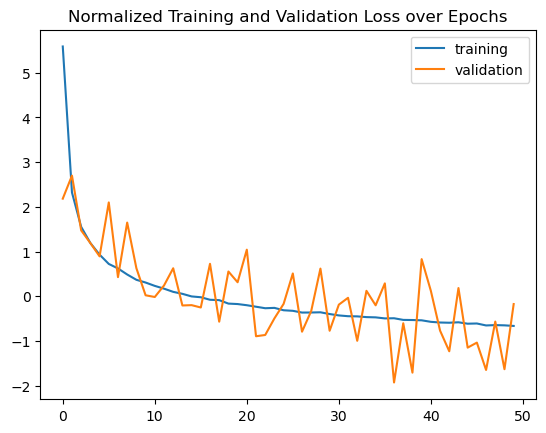

In [85]:
x_ax = history_nprelim.epoch
plt.plot(x_ax, norm_nloss, label="training")
plt.plot(x_ax, norm_val_nloss, label="validation")
plt.title("Normalized Training and Validation Loss over Epochs")
plt.legend()
plt.show()

## Save NN Model

In [30]:
# after training, save:
NN_model_nprelim.save(os.path.join(recon_model_path,'NN_model_nprelim_1.h5'))

## Test NN Model

In [86]:
NN_model_nprelim = load_model(os.path.join(recon_model_path,'NN_model_nprelim_1.h5'))

In [87]:
y_pred_nprelim = NN_model_nprelim.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nprelim_rerun)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 655us/step
MSE: 0.10


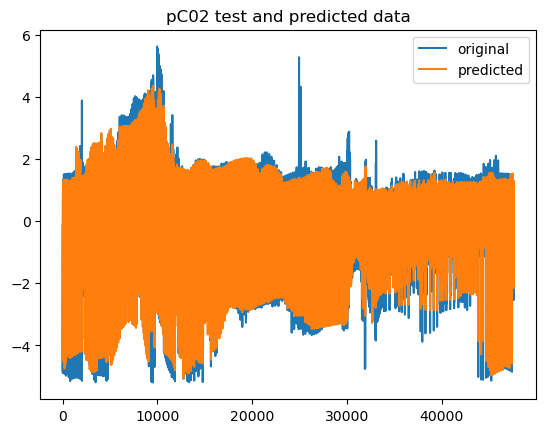

In [88]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_nprelim, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on normalized data, as is standard machine learning practice
- Comparison completed above for group reference, as data has not historically been normalized prior to training

## Parameters

Experimentation with hyperparameters completed below

### Experiment with NN Model

In [92]:
# set hyperparameters
n_neuron       = 100
activation     = 'LeakyReLU'
num_epochs     = 100
learning_rate  = 0.002
minibatch_size = 64
model_num      = 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [95]:
NN_model_exp = Sequential()

NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_1', input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_2')) # the 2nd hidden layer
NN_model_exp.add(Dense(n_neuron,  activation=activation, name='hidden_layer_3')) # the 3rd hidden layer
NN_model_exp.add(Dense(1,  activation='linear', name='output_layer')) # the output layer


NN_model_exp.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [96]:
NN_model_exp.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1100      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


### Train Experimental NN Model

In [97]:
history_exp = NN_model_exp.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.1818 - val_loss: 0.1942
Epoch 2/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.1149 - val_loss: 0.1864
Epoch 3/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.1019 - val_loss: 0.1620
Epoch 4/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.0939 - val_loss: 0.1578
Epoch 5/100
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0907 - val_loss: 0.1841
Epoch 6/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.0845 - val_loss: 0.1595
Epoch 7/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.0827 - val_loss: 0.1699
Epoch 8/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.0792 - val_loss: 0.1538
Epoch 9/100
2483/2483 [==============================] - 4s 1ms/step - loss: 0.0776 - val_loss: 0.1745
Epoch 10/100
2483/2483 [==============================] - 4s 1ms/step - l

### Initial Checks on Experimental NN Model

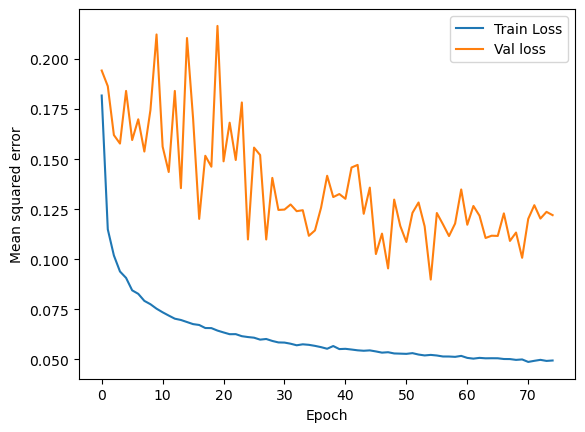

In [98]:
model_utils.plot_history(history_exp)

In [101]:
y_pred_exp = NN_model_exp.predict(X_test)
mse = mean_squared_error(y_test, y_pred_exp)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 823us/step
MSE: 0.09


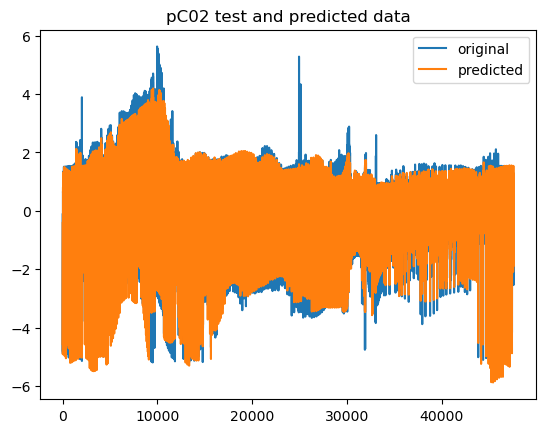

In [103]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_exp, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

### Save Best Experimental NN Model as First of NN Below

In [30]:
# after training, save:
NN_model_exp.save(os.path.join(recon_model_path,'NN_model1.h5'))

# Five Identical NN Models 

## NN Model 1

In [ ]:
NN_model1 = load_model(os.path.join(recon_model_path,'NN_model1.h5'))

## NN Model 2

## NN Model 3

## NN Model 4

## NN Model 5